In [9]:
import numpy as np
import pandas as pd
import rasterio
import torch

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, Subset


class CloudSegmentationDataset(Dataset):
    def __init__(self, csv_file: Path) -> None:
        self.data = pd.read_csv(csv_file)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        row = self.data.iloc[idx]

        channels = []
        for band in ["red", "green", "blue", "near_infrared"]:
            with rasterio.open(row[band]) as src:
                img = src.read(1).astype(np.float32) / 65535.0  # 2D image
                channels.append(img)

        image = np.stack(channels, axis=0)  # (4, H, W)

        with rasterio.open(row["target"]) as src:
            target = src.read(1).astype(np.uint8)  # 2D mask

        return torch.tensor(image, dtype=torch.float32), torch.tensor(target, dtype=torch.long)


dataset = CloudSegmentationDataset(
    Path(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\data\cloud_segmentation_dataset.csv")
)
loader = DataLoader(dataset, batch_size=4, shuffle=True)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class UNetBinary(nn.Module):
    def __init__(self, in_channels=4):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.down4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, 1, kernel_size=1)  # 1 canal = binaire

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))

        bottleneck = self.bottleneck(self.pool4(d4))

        u4 = self.up4(bottleneck)
        u4 = torch.cat([u4, d4], dim=1)
        u4 = self.conv4(u4)

        u3 = self.up3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)

        return self.out(u1)  # pas de sigmoid ici → à gérer dans la loss ou à l'inférence


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

import matplotlib.pyplot as plt


def train_model(
    model,
    dataset,
    epochs=10,
    batch_size=4,
    lr=1e-3,
    val_split=0.2,
    device="cuda" if torch.cuda.is_available() else "cpu",
):
    # Split du dataset

    if len(dataset) < 2:
        raise ValueError("Dataset is too small for training and validation. Minimul length is 2.")

    val_size = max(1, int(len(dataset) * val_split))
    train_size = len(dataset) - val_size

    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    # Loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    # Optimiseur et loss
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    # Envoi modèle sur GPU ou CPU
    model = model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0.0

        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device).unsqueeze(1).float()  # (B, H, W) → (B, 1, H, W)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device).unsqueeze(1).float()

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)

        train_losses.append(train_loss / train_size)
        val_losses.append(val_loss / val_size)

        print(
            f"Epoch {epoch}/{epochs} | Train Loss: {train_loss / train_size:.4f} | Val Loss: {val_loss / val_size:.4f}"
        )

    return train_losses, val_losses


def plot_losses(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


c:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\.venv\Lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1/2 | Train Loss: 42.2437 | Val Loss: 18.4876
Epoch 2/2 | Train Loss: -25.1157 | Val Loss: 13.4385


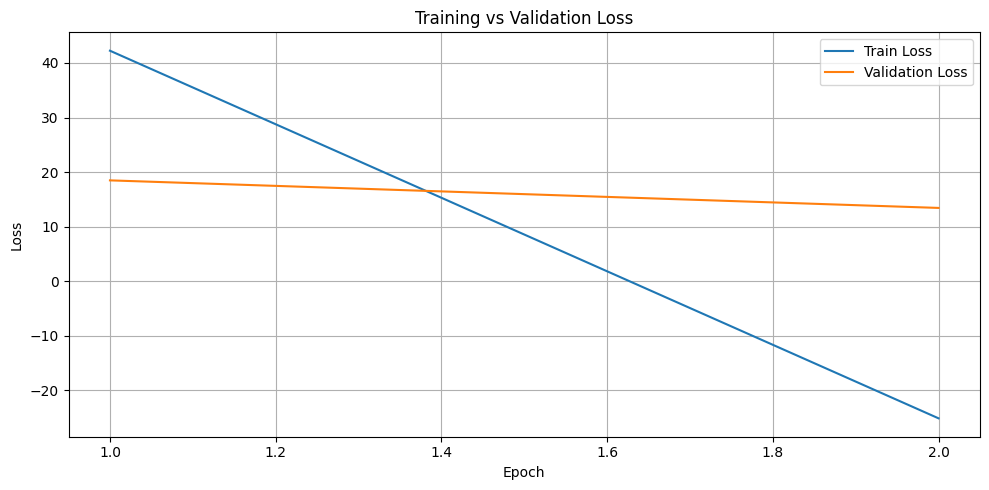

In [19]:
model = UNetBinary(in_channels=4)
dataset = CloudSegmentationDataset(
    Path(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite\data\cloud_segmentation_dataset.csv")
)
dataset = Subset(dataset, range(0, 4))  # use a small subset for quick training
train_losses, val_losses = train_model(model, dataset, epochs=2, batch_size=4, lr=1e-3)
plot_losses(train_losses, val_losses)

In [ ]:
import matplotlib.pyplot as plt
import torch


def plot_predictions(dataset, model, n=5, threshold=0.5, device="cpu"):
    model.eval()
    fig, axes = plt.subplots(nrows=n, ncols=3, figsize=(12, 4 * n))
    fig.suptitle("RGB | TARGET | PREDICTION", fontsize=16)

    for i in range(n):
        image, target = dataset[i]
        input_tensor = image.unsqueeze(0).to(device)  # shape: (1, 4, H, W)

        with torch.no_grad():
            output = model(input_tensor)  # (1, 1, H, W)
            prob = torch.sigmoid(output)
            pred_mask = (prob > threshold).float().squeeze().cpu().numpy()

        rgb = image[:3].permute(1, 2, 0).cpu().numpy()  # (H, W, 3)
        target = target.cpu().numpy()

        # Correction auto si axes est 1D (si n == 1)
        row = axes[i] if n > 1 else axes

        row[0].imshow(rgb)
        row[0].set_title("RGB Composite")
        row[1].imshow(target, cmap="gray")
        row[1].set_title("Target Mask")
        row[2].imshow(pred_mask, cmap="gray")
        row[2].set_title("Predicted Mask")

        for ax in row:
            ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()


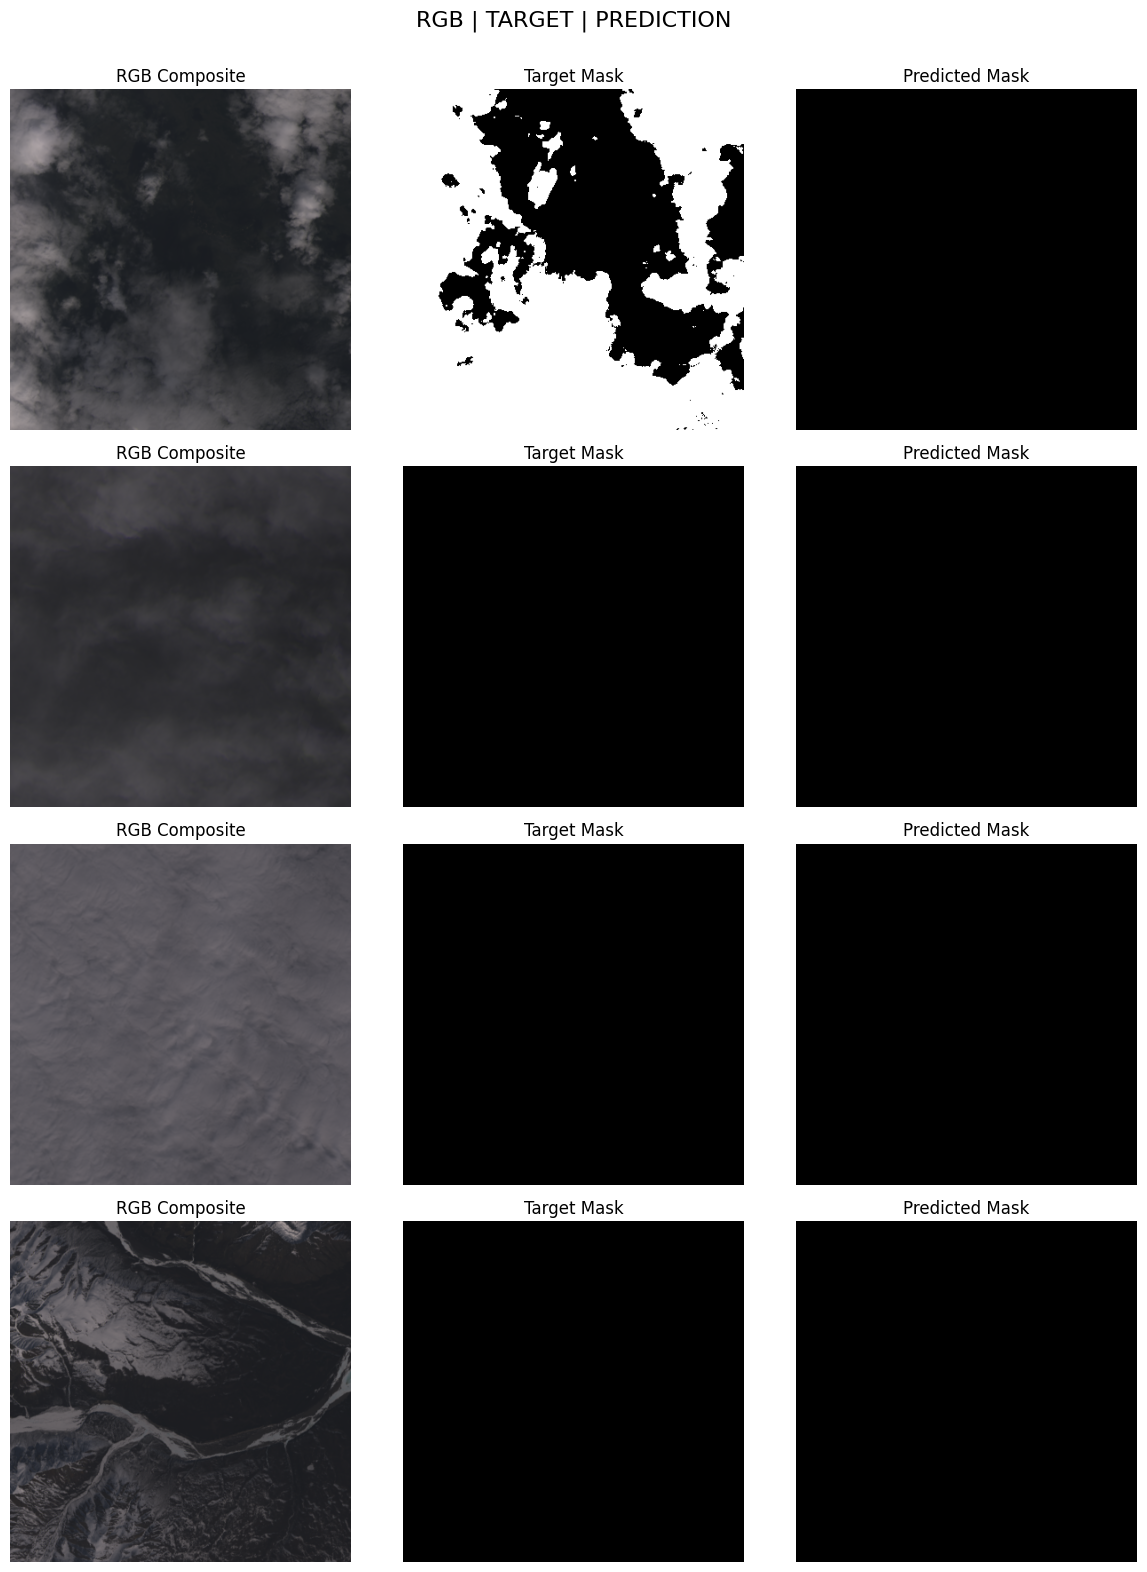

In [22]:
plot_predictions(dataset, model, n=4, device="cpu")


---


In [11]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)


class SimpleUNet(nn.Module):
    def __init__(self, in_channels: int = 3, out_channels: int = 1) -> None:
        super().__init__()
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = DoubleConv(128, 64)

        self.final = nn.Conv2d(64, out_channels, 1)

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))

        dec2 = self.up2(bottleneck)
        dec2 = self.dec2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.up1(dec2)
        dec1 = self.dec1(torch.cat([dec1, enc1], dim=1))

        return self.final(dec1)


def train_one_epoch(
    model: SimpleUNet,
    dataloader: DataLoader,
    optimizer: optim.Adam,
    criterion: nn.BCEWithLogitsLoss,
    device: torch.device,
) -> float:
    model.train()
    total_loss = 0
    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = CloudSegmentationDataset(
    images_root_directory=Path(r"C:\Users\giand\OneDrive\Documents\__packages__\_perso\satellite_data"),
    pytorch=True,
    is_training_dataset=True,
)

subset = Subset(dataset, range(0, 10))  # use a small subset for quick training
dataloader = DataLoader(subset, batch_size=4, shuffle=True)

model = SimpleUNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCEWithLogitsLoss()  # car binaire
optimizer = optim.Adam(model.parameters(), lr=1e-3)

number_of_epochs = 2
for epoch in range(number_of_epochs):
    loss = train_one_epoch(model, dataloader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

torch.save(model.state_dict(), f"models/{time.strftime('%Y%m%d')}_unet_{number_of_epochs}_epochs.pth")


Epoch 1, Loss: 0.5873
Epoch 2, Loss: 0.4090


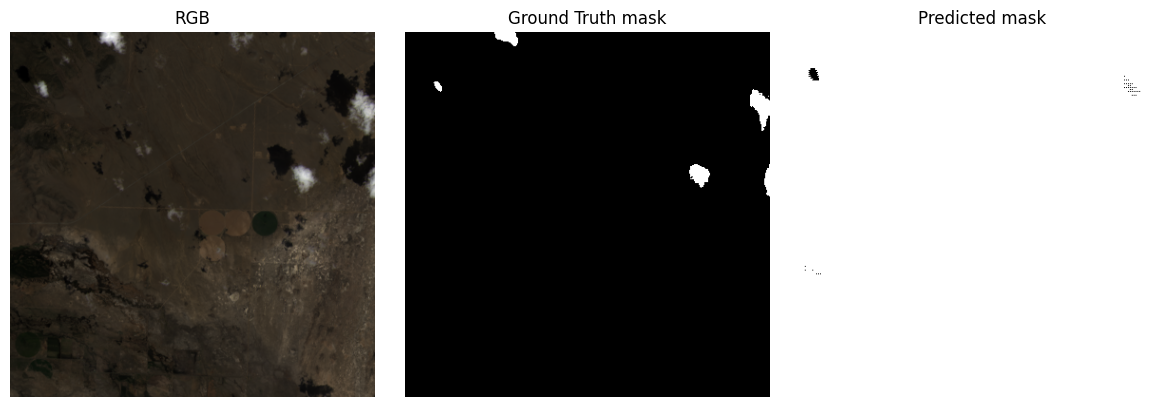

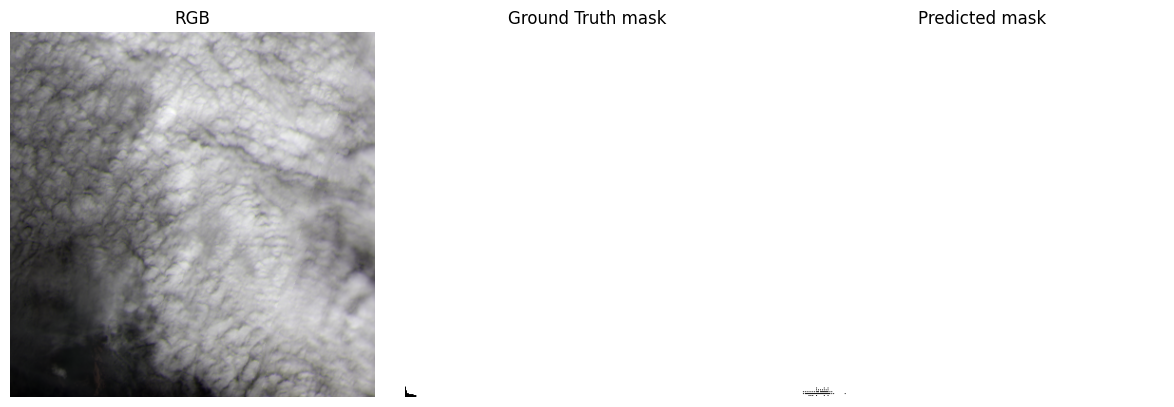

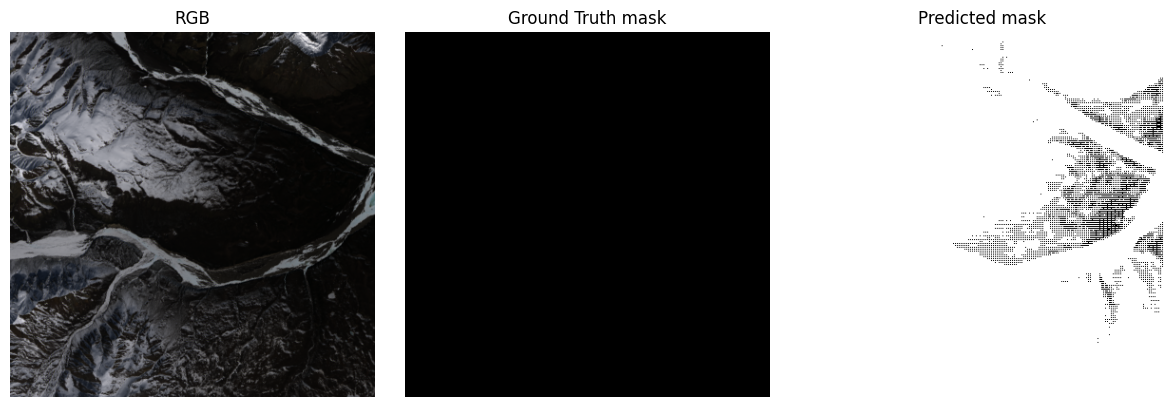

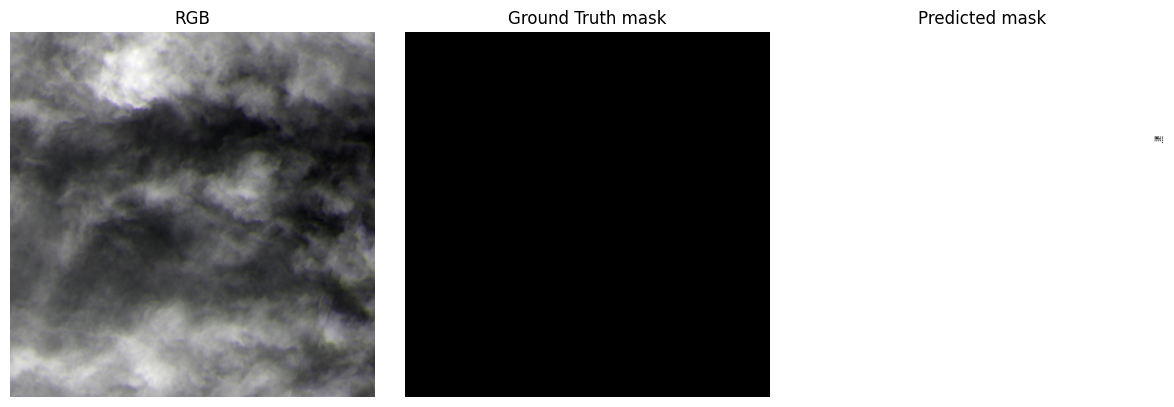

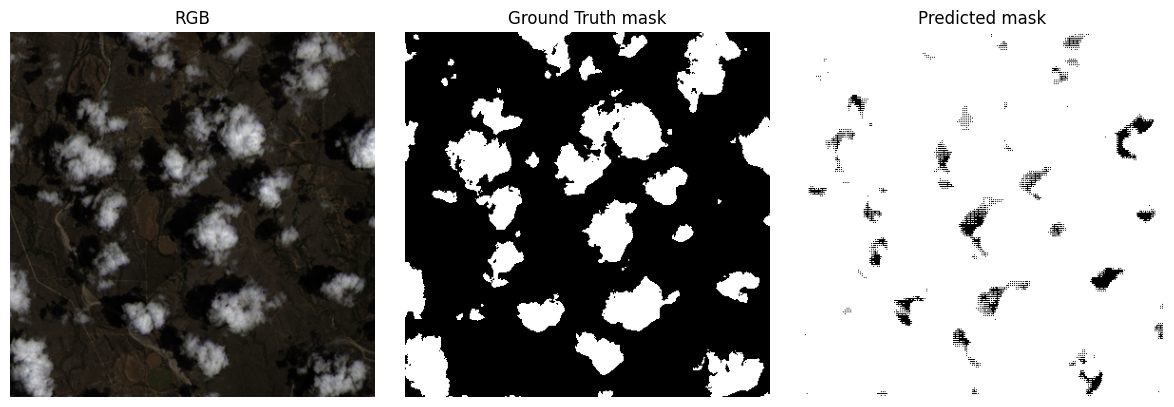

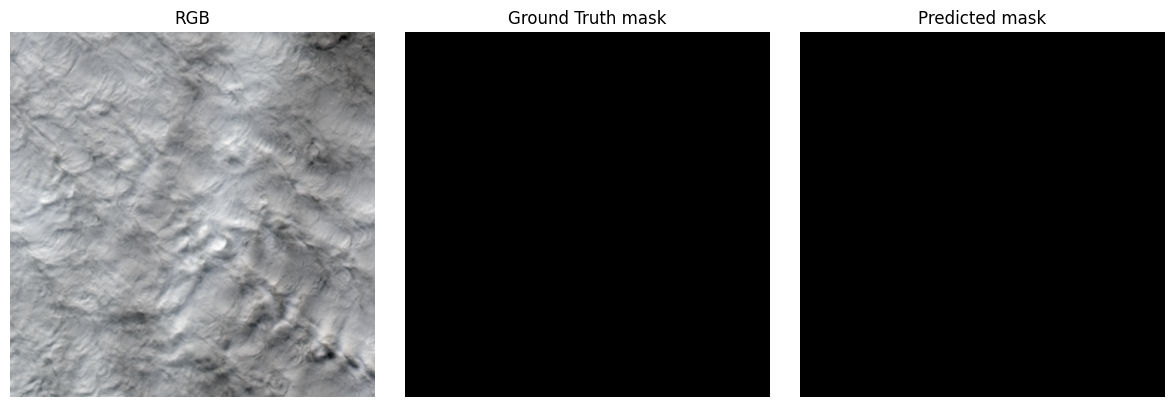

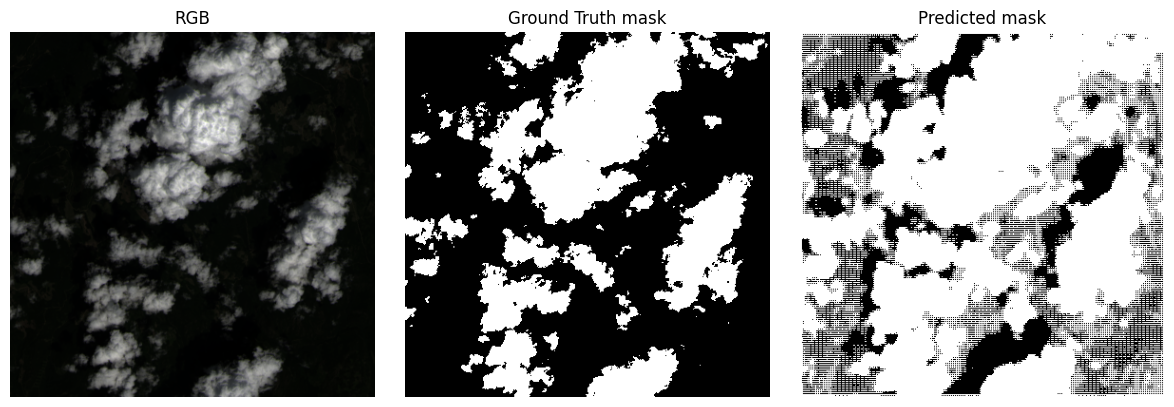

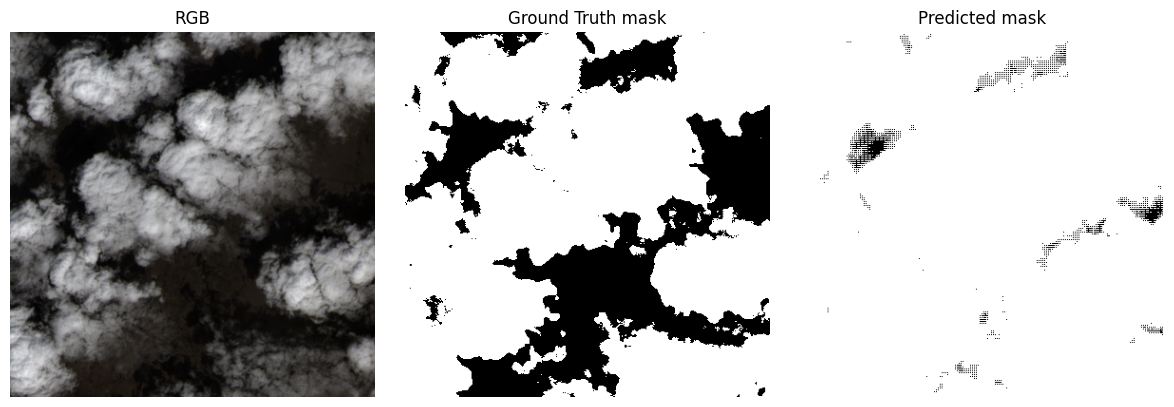

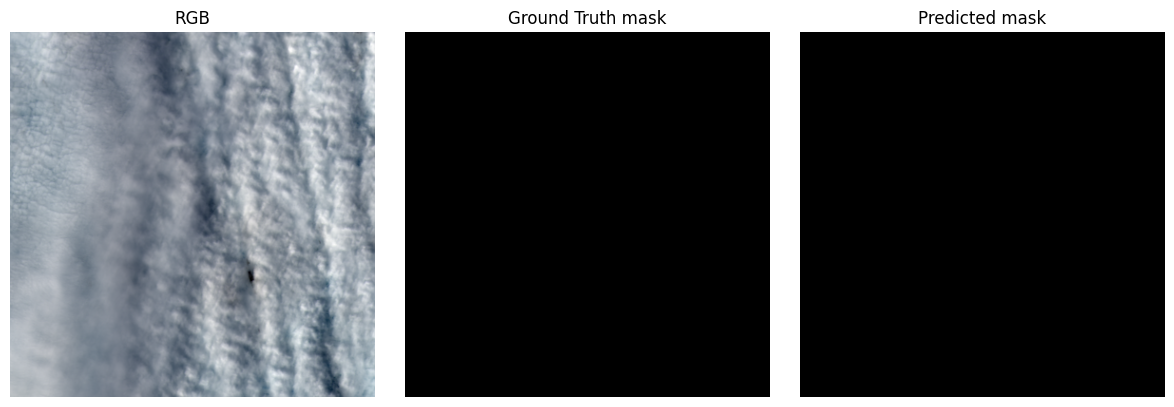

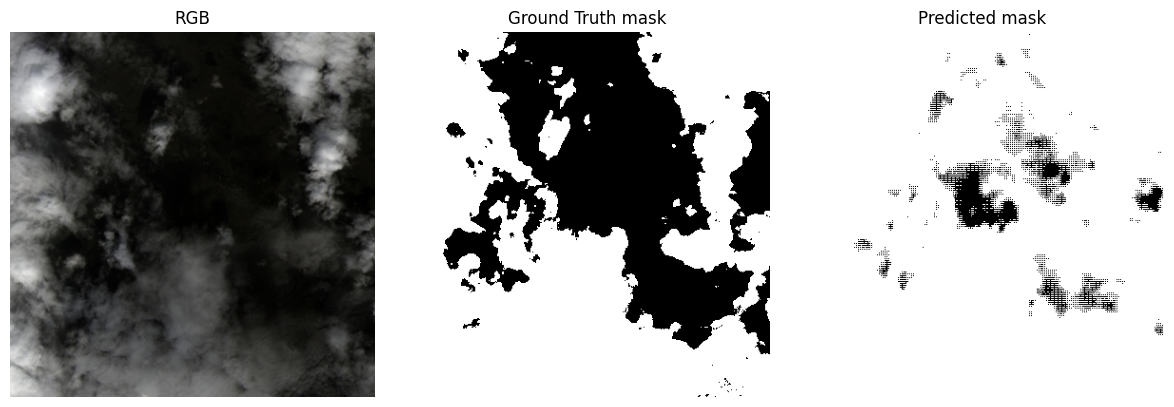

In [13]:
def show_predictions(model: SimpleUNet, dataloader: DataLoader, device: torch.device, num_images: int) -> None:
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5  # prediction threshold

            for i in range(inputs.size(0)):
                if images_shown >= num_images:
                    return

                rgb = inputs[i, :3].cpu().numpy().transpose(1, 2, 0)
                rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # normalize for visualization

                gt_mask = targets[i][0].cpu().numpy()
                pred_mask = preds[i][0].cpu().numpy()

                fig, axs = plt.subplots(1, 3, figsize=(12, 4))
                axs[0].imshow(rgb)
                axs[0].set_title("RGB")
                axs[1].imshow(gt_mask, cmap="gray")
                axs[1].set_title("Ground Truth mask")
                axs[2].imshow(pred_mask, cmap="gray")
                axs[2].set_title("Predicted mask")

                for ax in axs:
                    ax.axis("off")

                plt.tight_layout()
                plt.show()

                images_shown += 1


show_predictions(model, dataloader, device, num_images=10)


In [ ]:
torch.save(model.state_dict(), f"{time.strftime('%Y%m%d')}.pth")


In [18]:
model = SimpleUNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load("models/20250529_unet_subset4200_epoch9.pth", map_location="cpu"))
model.to("cpu")
model.eval()


SimpleUNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    

In [ ]:
prediction = torch.sigmoid(prediction).squeeze(0).squeeze(0).detach().numpy()
plt.imshow(prediction, cmap="gray")
plt.imshow(data.open_mask(0), cmap="gray", alpha=0.5)
plt.axis("off")
plt.show()

RuntimeError: Input type (double) and bias type (float) should be the same